In [ ]:
import sys
import os

# 1. Get current path (examples folder)
current_dir = os.getcwd()

# 2. Add 'src' to the path (NOT the project root)
# This mimics how pip installs the package
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))

if src_path not in sys.path:
    sys.path.append(src_path)

from landmark_triangulation.core import LandmarkTriangulation

Generating 2000 samples with 50 dimensions and 5 clusters...
Running SLR (Random)...
 -> Finished in 0.1807s | Silhouette Score: 0.8068
Running SLR (Synthetic)...
 -> Finished in 0.1368s | Silhouette Score: 0.3377
Running SLR (Hybrid)...
 -> Finished in 0.1625s | Silhouette Score: 0.6112
Running t-SNE (Benchmark)...
 -> Finished in 4.6294s | Silhouette Score: 0.8383


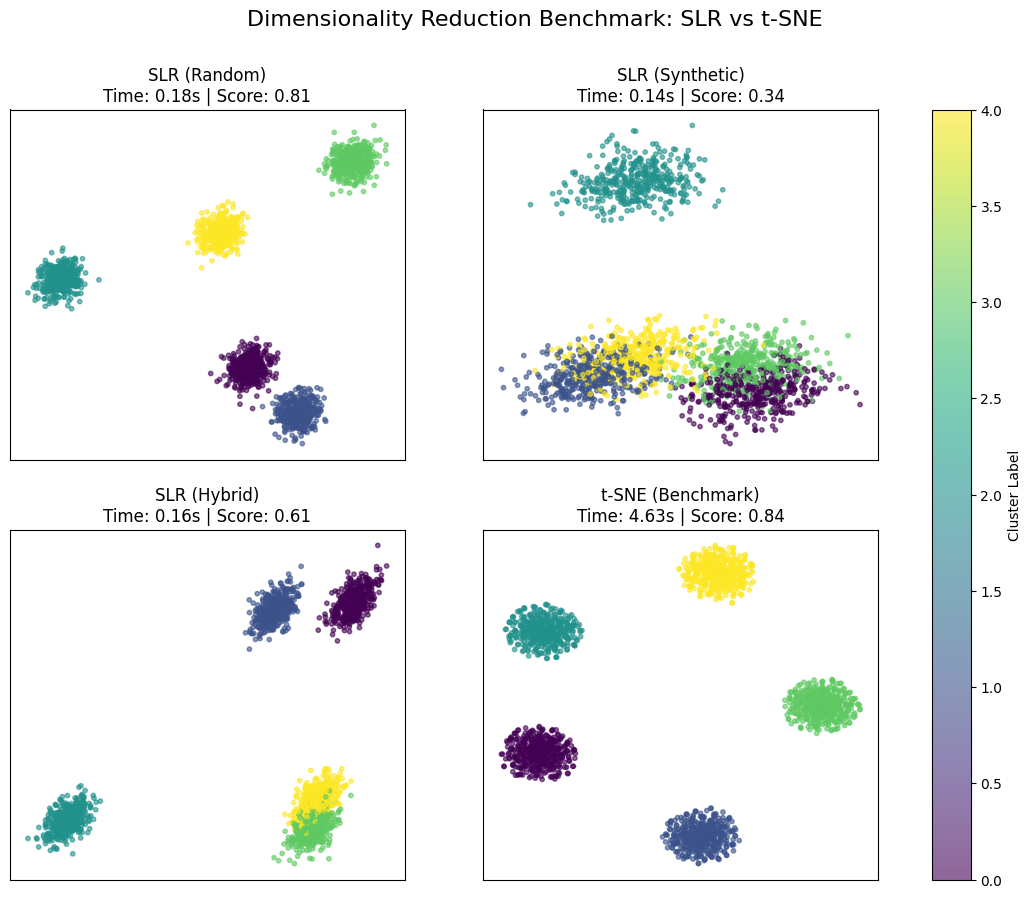


FINAL RESULTS SUMMARY
           Method  Time (sec)  Silhouette Score
     SLR (Random)    0.180683          0.806795
  SLR (Synthetic)    0.136755          0.337700
     SLR (Hybrid)    0.162531          0.611236
t-SNE (Benchmark)    4.629378          0.838264


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os

# --- Metrics & Data Generation ---
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# --- Import Custom Package ---
# Ensure we can see the 'src' folder relative to this script
current_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from landmark_triangulation.core import LandmarkTriangulation

def generate_synthetic_data(n_samples=5000, n_features=50, n_clusters=5):
    """
    Generates high-dimensional synthetic data with distinct clusters.
    """
    print(f"Generating {n_samples} samples with {n_features} dimensions and {n_clusters} clusters...")
    
    # Generate isotropic Gaussian blobs
    X, y = make_blobs(n_samples=n_samples, 
                      n_features=n_features, 
                      centers=n_clusters, 
                      cluster_std=2.0, 
                      random_state=42)
    return X, y

def run_method(name, model, X, y):
    """
    Runs a single dimensionality reduction model, times it, and scores it.
    """
    print(f"Running {name}...")
    start_time = time.time()
    
    # Run the reduction
    X_embedded = model.fit_transform(X)
    
    duration = time.time() - start_time
    
    # Calculate Quality: Silhouette Score (Higher is better)
    # Measures how similar an object is to its own cluster compared to other clusters.
    score = silhouette_score(X_embedded, y)
    
    print(f" -> Finished in {duration:.4f}s | Silhouette Score: {score:.4f}")
    
    return {
        "Method": name,
        "Time (sec)": duration,
        "Silhouette Score": score,
        "Embedding": X_embedded
    }

def main():
    # 1. Generate Data on the fly
    X, y = generate_synthetic_data(n_samples=2000, n_features=50, n_clusters=5)
    
    # 2. Define the contenders
    contenders = [
        ("SLR (Random)", LandmarkTriangulation(n_landmarks=150, landmark_mode="random")),
        ("SLR (Synthetic)", LandmarkTriangulation(n_landmarks=150, landmark_mode="synthetic")),
        ("SLR (Hybrid)", LandmarkTriangulation(n_landmarks=150, landmark_mode="hybrid")),
        ("t-SNE (Benchmark)", TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42))
    ]
    
    results = []
    
    # 3. Setup Plotting Grid (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # 4. Run Loop
    for i, (name, model) in enumerate(contenders):
        # Run experiment
        res = run_method(name, model, X, y)
        results.append(res)
        
        # Plot
        ax = axes[i]
        emb = res["Embedding"]
        scatter = ax.scatter(emb[:, 0], emb[:, 1], c=y, cmap='viridis', alpha=0.6, s=10)
        ax.set_title(f"{name}\nTime: {res['Time (sec)']:.2f}s | Score: {res['Silhouette Score']:.2f}")
        ax.grid(True, alpha=0.2)
        
        # Remove ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])

    # Add a single colorbar for the whole figure
    fig.colorbar(scatter, ax=axes.ravel().tolist(), label='Cluster Label')
    fig.suptitle("Dimensionality Reduction Benchmark: SLR vs t-SNE", fontsize=16)
    
    plt.show()
    
    # 5. Print Summary Table
    print("\n" + "="*50)
    print("FINAL RESULTS SUMMARY")
    print("="*50)
    
    df_results = pd.DataFrame(results)[["Method", "Time (sec)", "Silhouette Score"]]
    print(df_results.to_string(index=False))
    print("="*50)

if __name__ == "__main__":
    main()